*Before we get started, please note that I put in magic pip install lines to install everything this code needs to run locally, uncomment if you need to. A local run of this entire script on my machine takes about 20 minutes. Only running from the final model section on takes about 3-4 minutes. The best model found from the hyperparameter search is manually entered into every section after that section. You can run the imports, the dataframe read, and then any section you want seperately without waiting for the grid search.*

In [1]:
# %pip install pandas
# %pip install matplotlib
# %pip install sklearn
# %pip install seaborn
# %pip install numpy
# %pip install shap

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_predict, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import roc_curve
from sklearn.tree import plot_tree
from sklearn import metrics
import seaborn as sns
import numpy as np
from scipy import stats

import shap


In [3]:
if True:
    custom_style = {'axes.labelcolor': 'white',
                'xtick.color': 'white',
                'ytick.color': 'white'}
    sns.set_style("darkgrid", rc=custom_style)
    plt.style.use("dark_background")
    I_like_dark_mode_plots = True

In [5]:
#setting custom colors for later
my_blue = '#2B59C3'
my_green = '#63C132'
my_red = '#DA2C38'

# Predicting Churn from Iranian Telecom Customer Data
*Data graciously hosted by UC Irvine at DOI:[10.24432/C5JW3Z](https://doi.org/10.24432/C5JW3Z)*

This project is all about constructing an effective binary classification model to predict customer churn from a variety of data randomly collected by an Iranian telecom company. By the end of this writeup we'll have a very effective model for predicting customer churn, explored the feature importance of that model, and proposed next steps. In the bonus section we'll also use probability tuning to turn our binary prediction into a probabilistic one without hurting the f1 score.

Table of contents (anchors don't work on github's jupyter viewer, visit this notebook hosted at  <a href="https://nbviewer.org/github/MathiasVanPatten/iranian_churn_tele/blob/main/main.ipynb">nbViewer</a>) Click on any 
1. [Introduction to the dataset](#1)
2. [Exploratory data analysis](#2)
3. [Naive model training for benchmarking](#3)
4. [Hyperparameter searching](#4)
5. [Choosing a model](#5)
6. [Final model performance and feature importance](#6)
7. [Conclusions, suggested next steps](#7)

## Introduction to the dataset <a class="anchor" name="1"></a>
The dataset comes clean, with no missing values for 3150 customers. It has 9 months of data for the features. The label, churn, is evaluated at the 12 month mark. It has the following columns, sorted by type.

- Features
    - Binary
        - Complains (0: did not complain during the time period, 1: did complain during the time period)
        - Tariff Plan (1: Pay as you go, 2: Contractual)
        - Status (1: active, 2: non-active, what this means is not stated)
    - Ordinal
        - Charge Amount (0: lowest amount, 9: highest amount)
        - Age Group (1: youngest age group, 5: oldest age group)
    - Continuous
        - Call  Failure (int, number of call failures)
        - Seconds of Use (int, total seconds of calls)
        - Frequency of use (int, total number of calls)
        - Frequency of SMS (int, total number of text messages)
        - Distinct Called Numbers (int, total number of distinct phone calls)
        - Customer Value (float, the value of the customer, method and denomination not stated)
        - Age (int, seems to be the center of the age group bin the customer is in)
        - Subscription  Length (int, likely taken at the end of the 9 month period)
- Labels
    - Churn (binary, int, 0: did not churn between 9 and 12 months, 1: did churn between 9 and 12 months)

I will use all features except age and status. I neglect age because it is functionally a repetition of age group and neglet status because I'm not able to find out the meaning of it and want to avoid data leakage.

In [4]:
df = pd.read_csv("data/Customer Churn.csv", delimiter=",")
cont_keys = ['Call  Failure', 'Seconds of Use' , 'Frequency of use', 'Frequency of SMS', 'Distinct Called Numbers', 'Customer Value', 'Subscription  Length']
ordinal_keys = ['Age Group', 'Charge  Amount']
binary_keys = ['Tariff Plan', 'Complains']

predictor_keys = [x for x in df.keys() if not (x  in ['Churn', 'Status', 'Age'])]
label_key = ['Churn']
df.head()
df = df[predictor_keys+label_key]

## Exploratory data analysis <a class="anchor" name="2"></a>

First let's check for any missing data

In [7]:
df.isnull().sum()

Call  Failure              0
Complains                  0
Subscription  Length       0
Charge  Amount             0
Seconds of Use             0
Frequency of use           0
Frequency of SMS           0
Distinct Called Numbers    0
Age Group                  0
Tariff Plan                0
Customer Value             0
Churn                      0
dtype: int64

No missing data we have to deal with. Let's look at our label distribution

In [8]:
df.Churn.value_counts(normalize = True)

Churn
0    0.842857
1    0.157143
Name: proportion, dtype: float64

Again, 1 is that the customer churned between 9 and 12 months and 0 is they did not. The majority of customers didn't churn which is great! The label classes are heavily imbalanced, [~84.3%,~15.7%]. Instead of resampling we'll keep it in mind and change the class weights down the line, I prefer this to resampling if it's available.

Let's take a look at the histograms of all our continuous variables

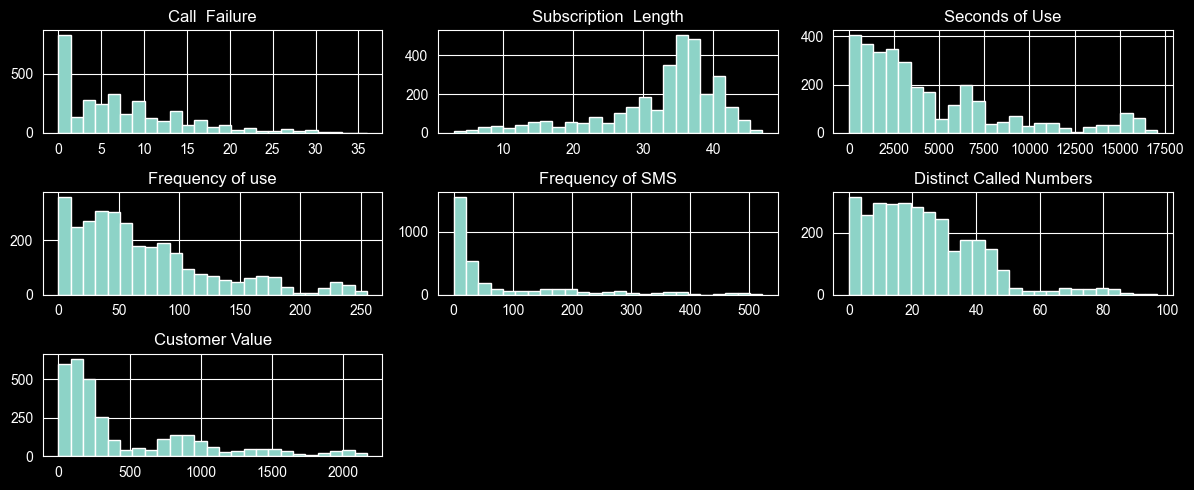

In [9]:
df[[x for x in df.keys() if x in cont_keys]].hist(bins=25, figsize= (12,5))
plt.tight_layout()

Every continuous variable is non-normal here. Even subscription length, which is the closest to normal, has a giant left sided tail. I notice an interesting wavy pattern in frequency of use, frequency of sms, and customer value where there seems to be some kind of attenuating bouncing. Could be worth future investigation but shouldn't effect our prediction.

Let's see what the histograms for the ordinal and binary values look like

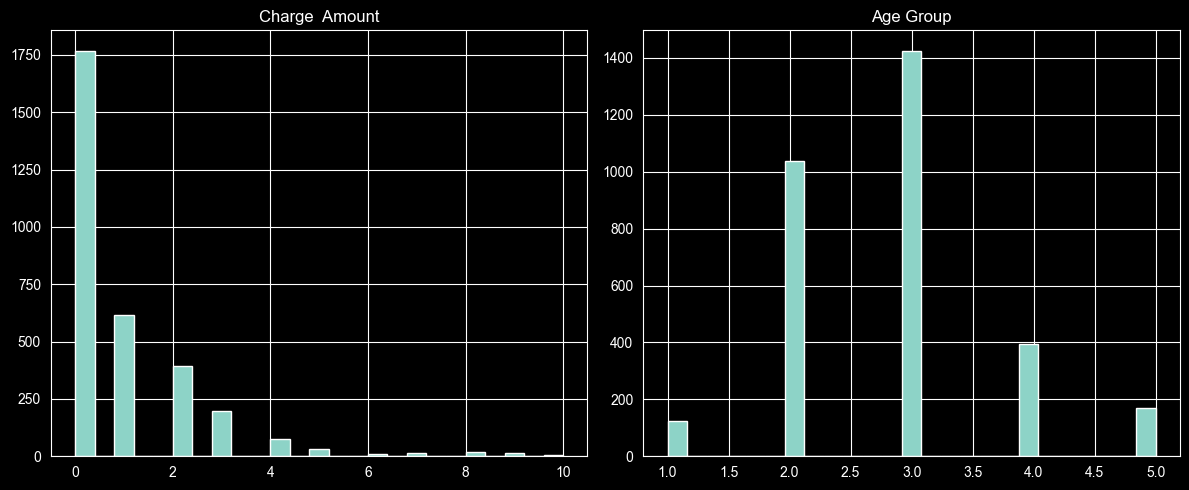

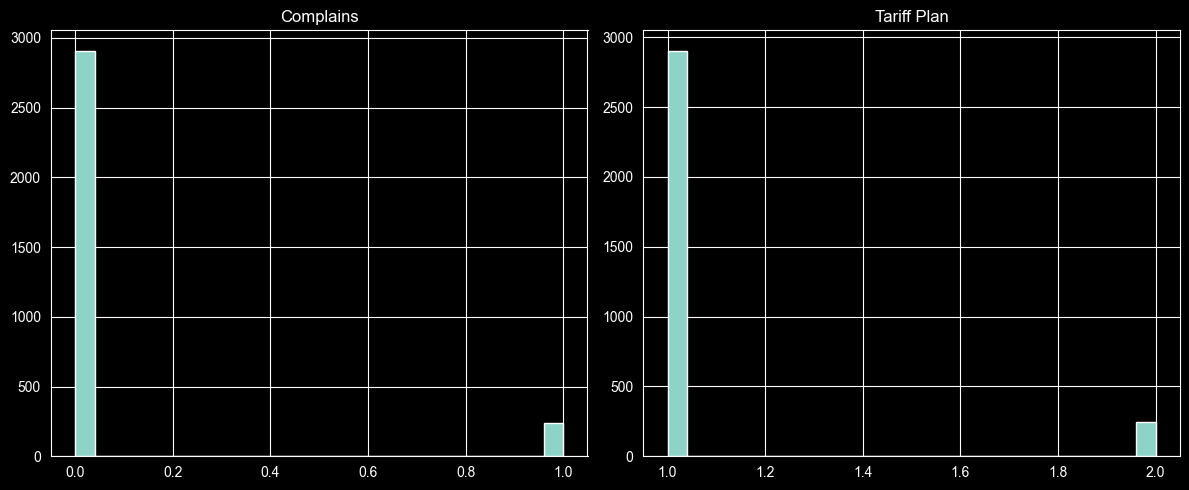

In [10]:
df[[x for x in df.keys() if x in ordinal_keys]].hist(bins=25, figsize= (12,5))
plt.tight_layout()
df[[x for x in df.keys() if x in binary_keys]].hist(bins=25, figsize= (12,5))
plt.tight_layout()

Charge amount is going down exponentially, age group is about normal, and both complains and tariff plan are heavily biased towards a single class.

Later on we'll rescale everything using RobustScalar inside the pipeline objects in sklearn so the transformation is done inside the model and we can maintain interpretability. I chose robust scalar because most of our data is far from normally distributed. I'm still 

Let's look at how the data relates to each other using a correlation matrix.

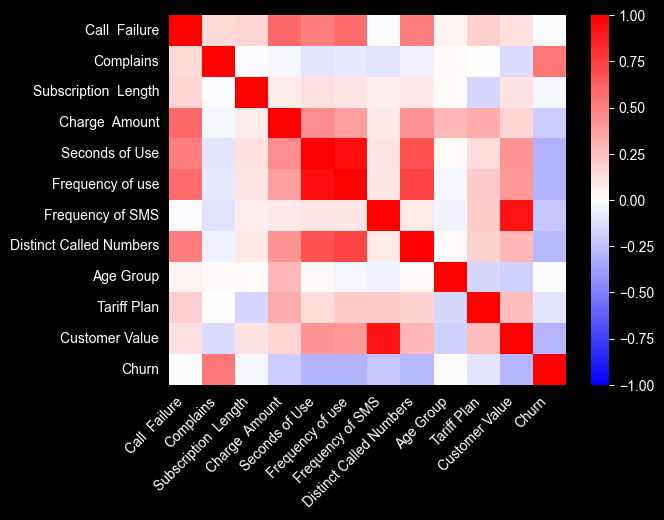

In [11]:
sns.heatmap(df.corr(), 
            xticklabels = df.columns.values, 
            yticklabels = df.columns.values, 
            cmap = 'bwr', vmin = -1, vmax = 1)
plt.xticks(rotation=45, ha='right');

So first, the non churn variables, here's what I'm seeing
- All the call usage variables are heavily correlated with each other, if this was going to be a causal model that'd be an issue and we'll have to keep it in mind for later when we do interpretability.
- Customer value heavily correlates with SMS which at first made me think we'd have to watch out for freq of SMS being heavily correlated with something else (like age group) such that customer value then could be mostly made up of that SMS correlated variable; however, SMS freq is only middling correlated with anything else so no worries.
- Looking now at churn only
    - For the continuous variables, in short it seems that the more someone uses the service, it's somewhat less likely they'll churn
    - For the ordinal variables, age doesn't seem to affect churn and charge amount has a suprising negative correlation with churn
    - For the binary, complaining correlates with leaving unsuprisingly and our pay as you go customers are slightly more likely to stay

Let's double check the pairplot since we know correlations can be misleading.

c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


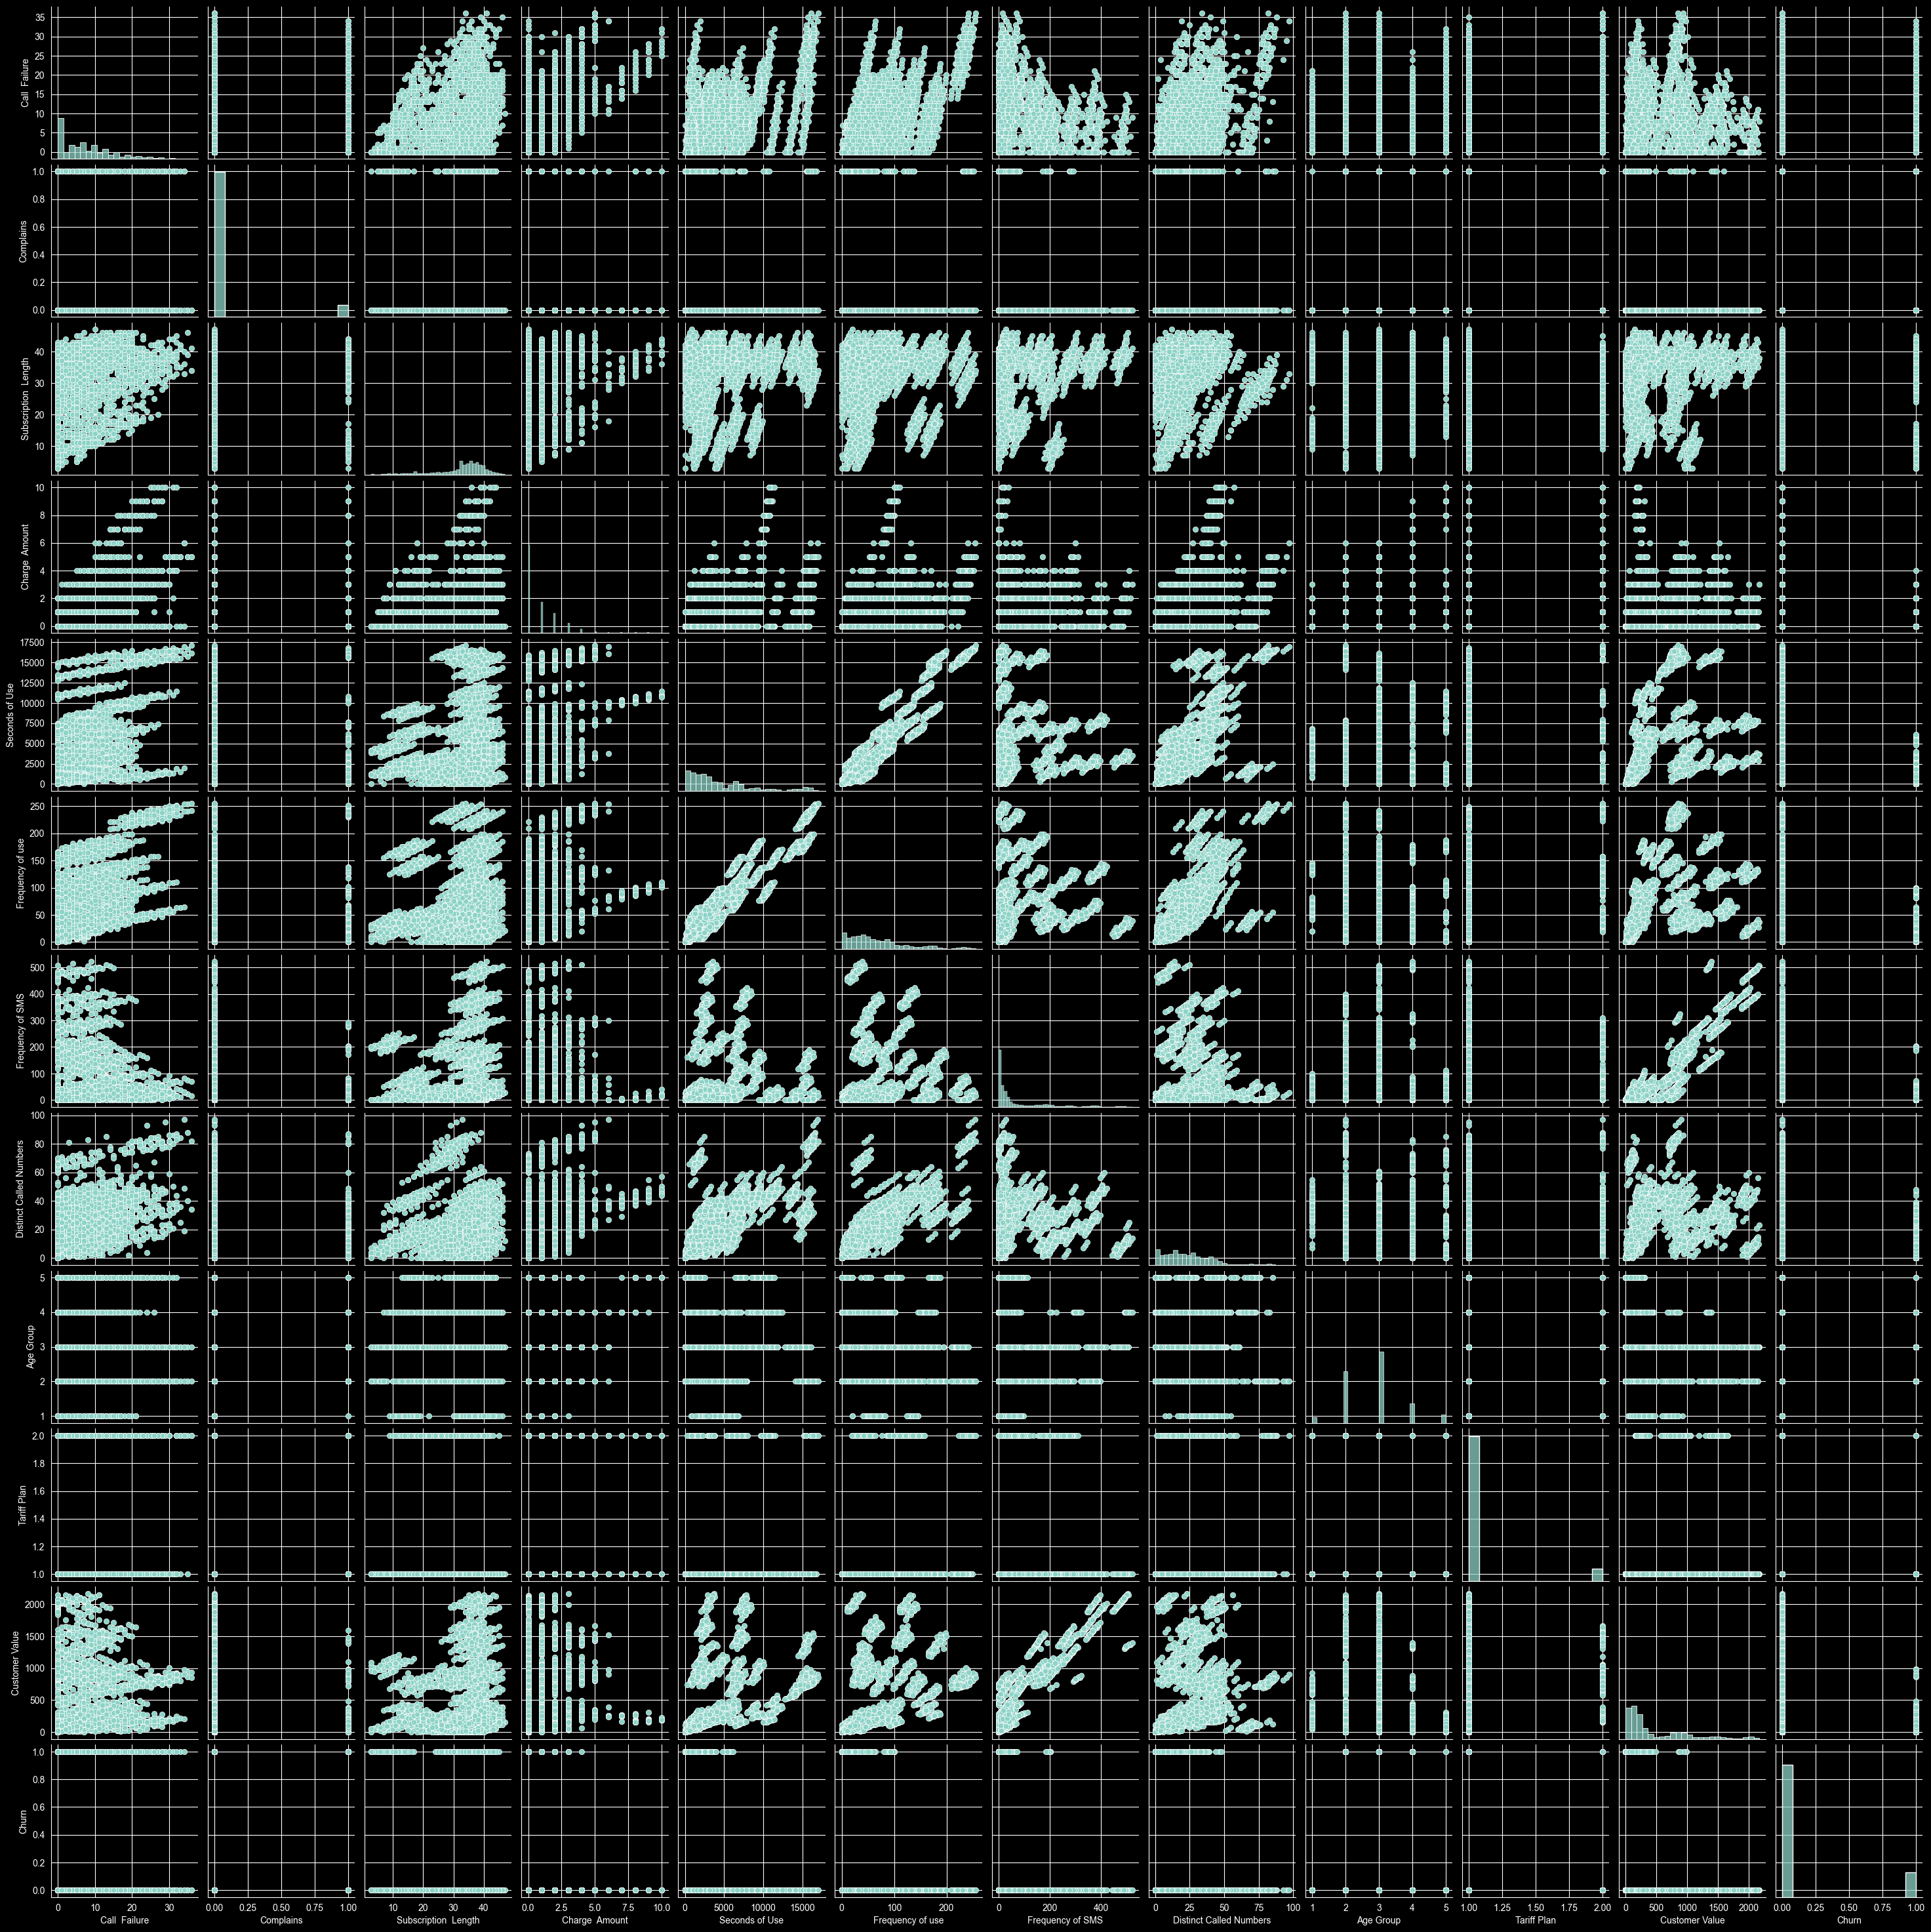

In [12]:
sns.pairplot(df, plot_kws={'alpha': 1})

Nothing here that refutes the correlations initial predictions about how each variable might effect a prediction. The streakiness stands out to me as well as the almost perfect lines in the data around use. I think this could be due to the majority of the customers being pay as you go with each cluster being another denomination of prepaid credit? The dataset isn't fully explained and we don't have access to more so we'll just have to accept the odd clustering and see if we can still get a good predictor.

The last thing I want to look at is how much the customers that we lose are worth. While that could inform the entire project, we'll be building the model no matter what comes up here.

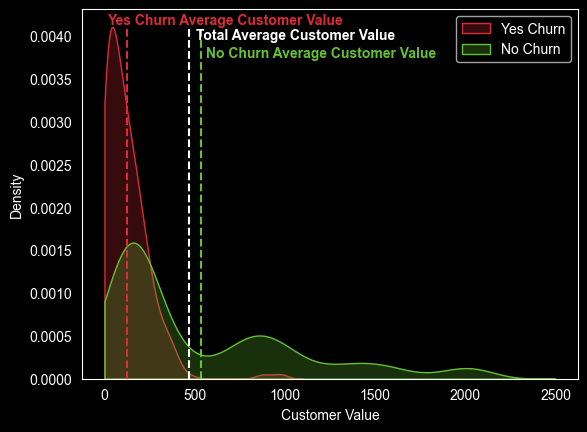

In [81]:
kde = sns.kdeplot(df[df.Churn == 1]['Customer Value'], fill=True, clip=(0, None), label = 'Yes Churn', color = my_red)

plt.vlines(np.mean(df[df.Churn == 1]['Customer Value'].values), 0, kde.dataLim.intervaly[1], linestyle = '--', color = my_red)
plt.text(0.05, 0.96, f'Yes Churn Average Customer Value',
                transform=plt.gca().transAxes, fontsize = 10, fontweight = 'semibold', color = my_red)

plt.vlines(np.mean(df['Customer Value'].values), 0, kde.dataLim.intervaly[1], linestyle = '--')
plt.text(0.23, 0.92, f'Total Average Customer Value', color='white',
                transform=plt.gca().transAxes, fontsize = 10, fontweight = 'semibold')

plt.vlines(np.mean(df[df.Churn == 0]['Customer Value'].values), 0, kde.dataLim.intervaly[1], linestyle = '--', color = my_green)
plt.text(0.25, 0.87, f'No Churn Average Customer Value',
                transform=plt.gca().transAxes, fontsize = 10, fontweight = 'semibold', color = my_green)

sns.kdeplot(df[df.Churn == 0]['Customer Value'], fill=True, clip=(0, None), label = 'No Churn', color = my_green)
kde.grid(False)
plt.legend()

The densities are individually normalized.

So interestingly almost every customer that churns is well below the total average customer value. There are some outliers around 1000 but it's very little.

Summing up this section, there's no variable that appears too problematic or trivial to include. Every additional variable does seem to have variation with the others (especially important for variables like number of calls and total call use) so we'll use every feature here to predict churn and see what we can do.

We'll also remember how our customer values are distributed when we get to the conclusion and what should we do section.

## Naive model training for benchmarking <a class="anchor" name="3"></a>

Since we're doing binary classification I want to evaluate three models. 
- Random Forest
- Histogram Boosted Gradient Classification (HGBC)
- Logistic Regression

The first two are because random forest can often be a strong and performative choice for binary classification with HGBC often improving upon both the accuracy and speed of random forest. Logistic regression is included as a comparison and is the reason why I apply the RobustScalar transformation to all of them. Tree based methods don't care about scaling but better to be safe and apply the same across everything we're testing.

We'll take a look at the ROC curve for all three without any hyperparameter tuning. Performance is average over the 5 repeats of a 5 fold stratified k fold cross validator to make sure we get a stable result and not just a lucky/unlucky draw for one model over another.

In [13]:
def make_cv_roc(model_library, df, return_f1_auc = False, n_repeat_cv = 5):
    fig, ax = plt.subplots()
    
    if I_like_dark_mode_plots:
        plt.plot([0,1], [0,1], linestyle = '--', c='white')
    else:
        plt.plot([0,1], [0,1], linestyle = '--', c='black')

    mean_fpr = np.linspace(0, 1, 100)

    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=n_repeat_cv)

    if return_f1_auc:
        f1_auc_dict = {}

    for model_name, model in model_library.items():
        tpr_stack=[]
        auc_stack=[]
        f1_stack=[]
        
        for train_inds, test_inds in cv.split(df[predictor_keys], df[label_key].values.ravel()):
            Xtrain = df[predictor_keys].iloc[train_inds]
            Xtest = df[predictor_keys].iloc[test_inds]
            Ytrain = df[label_key].values.ravel()[train_inds]
            Ytest = df[label_key].values.ravel()[test_inds]

            fit_model = model.fit(Xtrain, Ytrain)

            y_pred = fit_model.predict_proba(Xtest)[:,1]
            y_pred_binary = fit_model.predict(Xtest)
            
            f1 = metrics.f1_score(Ytest, y_pred_binary)
            f1_stack.append(f1)
            fpr, tpr, _ = roc_curve(Ytest, y_pred)
            tpr_stack.append(np.interp(mean_fpr, fpr, tpr))
            auc_stack.append(metrics.auc(fpr, tpr))

        mean_tpr = np.mean(tpr_stack, axis=0)
        mean_tpr[0] = 0
        mean_tpr[-1] = 1

        mean_auc = np.mean(auc_stack)
        mean_f1 = np.mean(f1_stack)
        if return_f1_auc:
            f1_auc_dict[model_name] = {}
            f1_auc_dict[model_name]['f1'] = np.array(f1_stack)
            f1_auc_dict[model_name]['auc'] = np.array(auc_stack)
        plt.plot(mean_fpr, mean_tpr, label = f'{model_name} ROC Curve, AUC: {mean_auc:.4f}, F1: {mean_f1:.4f}')
    
    plt.legend()
    plt.xlabel('False Positive Rate (Positive Label: 1)')
    plt.ylabel('True Positive Rate (Positive Label: 1)');
    if return_f1_auc:
        return f1_auc_dict

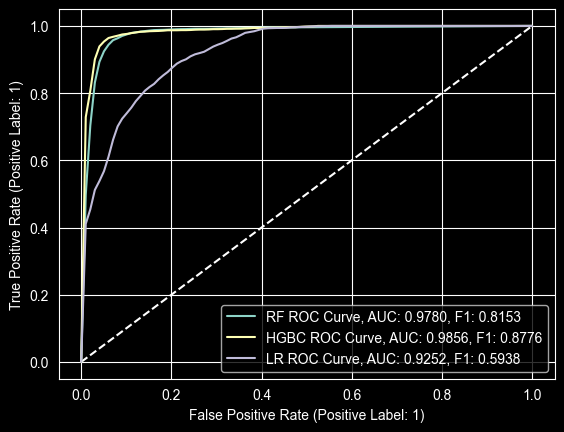

In [14]:
scaling_step = ColumnTransformer(transformers=[('scale', RobustScaler(), predictor_keys)])

model_pipelines = {
    'RF' : make_pipeline(scaling_step, RandomForestClassifier(class_weight = 'balanced_subsample')), #balanced class weight to compensate for unbalanced class label freq
    'HGBC' : make_pipeline(scaling_step, HistGradientBoostingClassifier(class_weight = 'balanced')),
    'LR' : make_pipeline(scaling_step, LogisticRegression(class_weight = 'balanced')) 
}

make_cv_roc(model_pipelines, df)

While logistic regression did fairly well, random forest and hgbc beat it out in both area under curve (AUC) and F1 score significantly without any tuning. Let's tune these two trees to see if we can differentiate better between them to make a final decision on which one we want to go with.

## Hyperparameter Searching <a class="anchor" name="4"></a>


For this project, we'll stay simple with grid searching. I'd like to discuss why I've chosen the values and parameters I have to search. 

The two objectives I have in mind are:
1. Tuning the model complexity, allowing the search to find that thin line between over and underfitting
2. Resource use, trying to reduce the end model's training and inference time. Also not letting the search itself get too big

By repeatadly doing smaller grid searches I can often find the right variables I need to do a bigger search and what range to do it over. This search is the big one that came out of that experimentation.

I do stratefied k fold validation for the grid search, the stratification helps to make sure we handle our uneven class labels properly. We don't want a training fold with little or no positive churn. We'll use 5 folds since that's typically a good amount with 3 repeats to make sure we're not just getting an odd run of luck.

*side note, I've dropped the scaling from now on, the two tree models we're looking at aren't effected by parameter scaling*

In [15]:
RF_hp = {
    'min_samples_leaf' : [1, 2, 3],
    'n_estimators' : [250, 500, 750, 1000],
    'max_depth' : [None, 20, 30],
}

HGBC_hp = {
    'min_samples_leaf' : [26, 31, 36, 41],
    'learning_rate' : [1e-2, 1e-1, 2.5e-1],
    'l2_regularization' : [0, 1e-2, 1e-1, 2.5e-1],
    'max_iter' : [50, 100, 150, 250]
}

hp_grid = {
    'RF' : RF_hp,
    'HGBC' : HGBC_hp
}

RF_HP_params = dict(
    min_samples_leaf = [1, 2, 3],
    n_estimators = [100, 250, 500, 1000],
    max_depth = [None, 10, 20, 30],
)

In [16]:
model_dict = {
    'RF' : RandomForestClassifier(class_weight = 'balanced_subsample'), #balanced class weight to compensate for unbalanced class label freq
    'HGBC' : HistGradientBoostingClassifier(class_weight = 'balanced')
}

In [17]:
grid_search_models = {}
for model_name, model in model_dict.items():
    print(f'Starting fit on {model_name}')
    grid_search = GridSearchCV(estimator = model, 
                               param_grid= hp_grid[model_name], 
                               cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 5), 
                               n_jobs =-1, 
                               scoring = 'f1', verbose = 10) #f1 scoring because it considers both true and false positives
    grid_search.fit(df[predictor_keys], df[label_key].values.ravel())
    grid_search_models[model_name] = grid_search


Starting fit on RF
Fitting 25 folds for each of 36 candidates, totalling 900 fits
Starting fit on HGBC
Fitting 25 folds for each of 192 candidates, totalling 4800 fits


## Choosing a model <a class="anchor" name="5"></a>

Now that we have the results from our rid search let's plot the average f1 score with 1 standard deviation on either side to make sure we choose a model with all the information we just made with that repeated cross validation. I'll only plot the top five performers (highest performing at the top decrementing).


In [18]:
pretty_model_names = {
    'RF' : "Random Forest",
    'HGBC' : "Histogram Gradient Boosted Classifier"
}

def make_comparison_figs(grid_search_models, parameter_of_interest, xlabel):
    for model_name, model_search in grid_search_models.items():
        error_plotter = pd.DataFrame(model_search.cv_results_)
        if model_name == 'RF':
            error_plotter['params'] = error_plotter['params'].apply(lambda x: f"Min Leaf: {x['min_samples_leaf']}, "
                                                                    f"N Est: {x['n_estimators']}, "
                                                                    f"MD: {x['max_depth']}")
        else:
            error_plotter['params'] = error_plotter['params'].apply(lambda x: f"Min Leaf: {x['min_samples_leaf']}, "
                                                                    f"LR: {x['learning_rate']}, "
                                                                    f"L2: {x['l2_regularization']}, "
                                                                    f"Max Iter: {x['max_iter']}")
            
        model_perf_sort_inds = np.argsort(error_plotter['mean_test_score'].values)[-5:]

        fig, ax = plt.subplots(figsize = (7,.5*len(model_perf_sort_inds)))
        plt.errorbar(error_plotter[f'mean_{parameter_of_interest}'].values[model_perf_sort_inds], 
                    range(len(model_perf_sort_inds)),
                    xerr = error_plotter[f'std_{parameter_of_interest}'].values[model_perf_sort_inds], fmt='o', color=my_blue,elinewidth= 2.5)
        ax.grid(False)
        plt.yticks(range(len(model_perf_sort_inds)), error_plotter['params'].values[model_perf_sort_inds]);
        plt.xlabel(xlabel)
        plt.title(f'{pretty_model_names[model_name]}, {xlabel}')
        plt.tight_layout()

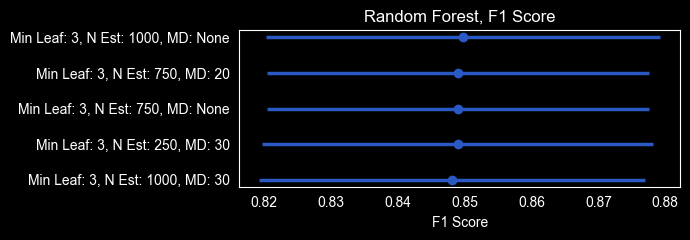

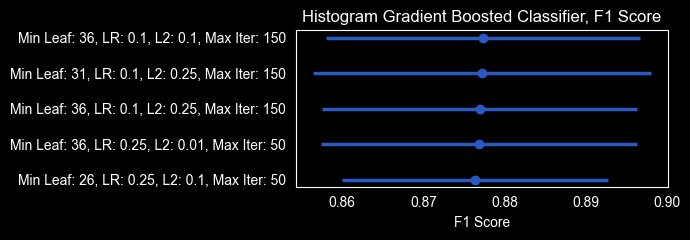

In [19]:
make_comparison_figs(grid_search_models, 'test_score', 'F1 Score')

Let's also check the inference and fit times for the top five performers (highest performing at the top decrementing).

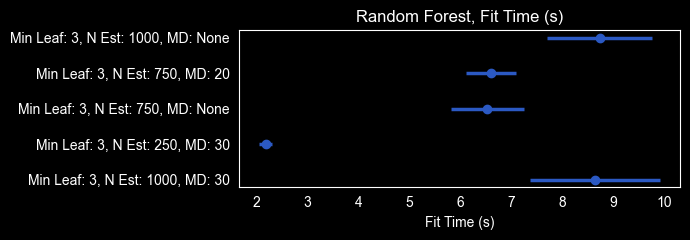

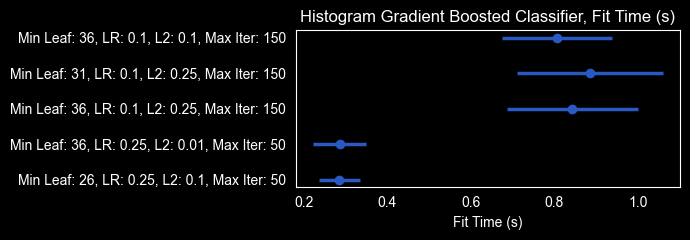

In [20]:
make_comparison_figs(grid_search_models, 'fit_time', 'Fit Time (s)')

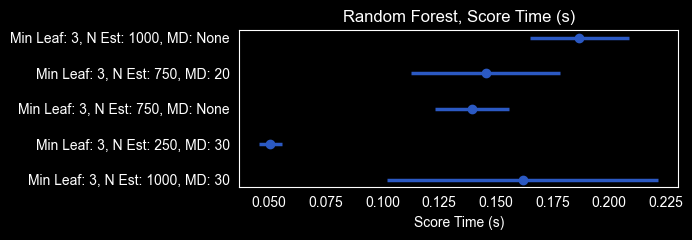

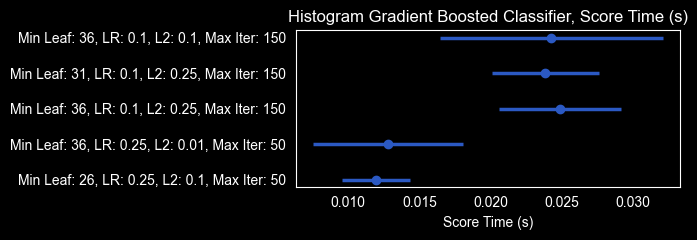

In [21]:
make_comparison_figs(grid_search_models, 'score_time', 'Score Time (s)')

Between the RF and HGBC models the HGBC win hands down. Not only do the HGBC models have higher average f1 score (~0.85 for the RF top performer vs ~0.88 for the HGBC) they also train and evaluate about 10x faster than random forest. Interestingly, the standard deviation in the f1 score peformance is about the same between the RF and HGBC models at around 2.5.

There aren't many stark differentiators between the top 5 HGBC candidates so we'll take the one with the highest average f1 score since the fit and score times are barely different for the top 5.

That means our best tuned model is sklearn's HistGradientBoostingClassifier with the follow kwargs
- class_weight = 'balanced'
- min_samples_leaf = 36
- learning_rate = 0.1
- l2_regularization = 0.1
- max_iter = 150

Now that we have our final model candidate, let's take a look at the roc curve to make sure our tuning efforts led to better performance. I'm cranking up the number of repeats we're doing here for the next section.

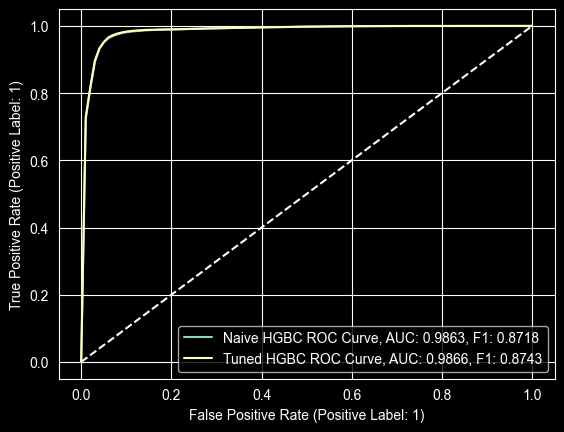

In [22]:
testing_models = {
    'Naive HGBC' : HistGradientBoostingClassifier(class_weight = 'balanced'),
    'Tuned HGBC' : HistGradientBoostingClassifier(class_weight = 'balanced', min_samples_leaf=36, learning_rate=0.1, l2_regularization=.1, max_iter=150)
}

f1_auc_info = make_cv_roc(testing_models, df, return_f1_auc = True, n_repeat_cv = 50)

They appear to be the same, let's use all the information we have and plot the contrast distributions for F1 and AUC just to make sure.

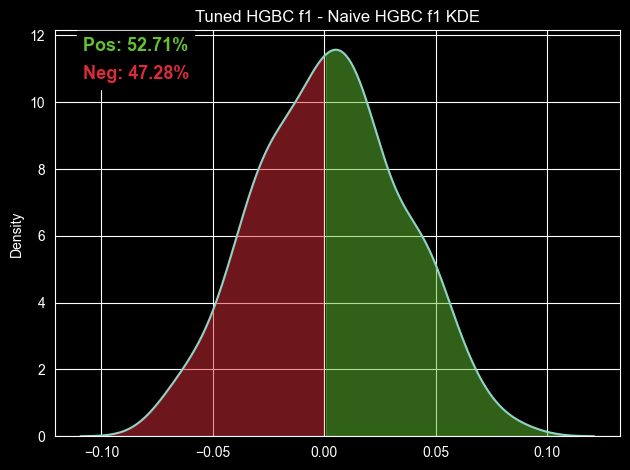

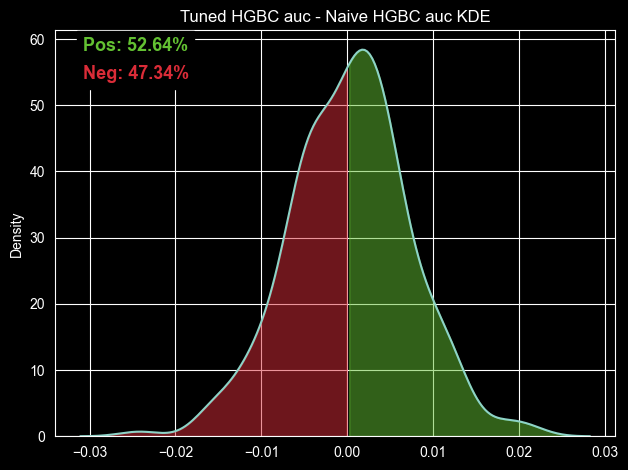

In [23]:
for var in ['f1', 'auc']:
    plt.figure()
    differences = f1_auc_info['Tuned HGBC'][var] - f1_auc_info['Naive HGBC'][var]
    
    kde_dat = sns.kdeplot(differences)
    kde_vals = kde_dat.get_lines()[0].get_data()[1]
    x_vals = kde_dat.get_lines()[0].get_data()[0]
    if I_like_dark_mode_plots:
        plt.fill_between(x_vals[x_vals > 0], kde_vals[x_vals > 0], color=my_green, alpha=0.5)
        plt.fill_between(x_vals[x_vals < 0], kde_vals[x_vals < 0], color=my_red, alpha=0.5)
    else:
        plt.fill_between(x_vals[x_vals > 0], kde_vals[x_vals > 0], color='g', alpha=0.5)
        plt.fill_between(x_vals[x_vals < 0], kde_vals[x_vals < 0], color='r', alpha=0.5)

    tot_density = np.trapz(x_vals, kde_vals)

    zero_ind = np.argmin(np.abs(x_vals))

    pos_density = np.trapz(x_vals[zero_ind:], kde_vals[zero_ind:]) / tot_density * 100
    neg_density = np.trapz(x_vals[:zero_ind], kde_vals[:zero_ind])/ tot_density * 100

    if I_like_dark_mode_plots:
        t = plt.text(0.05, 0.95, f'Pos: {pos_density:.2f}%', color=my_green,
                transform=plt.gca().transAxes, fontsize = 13, fontweight = 'semibold')
        t.set_bbox(dict(facecolor='black', edgecolor ='black'))
    else:
        t = plt.text(0.05, 0.95, f'Pos: {pos_density:.2f}%', color='k',
                transform=plt.gca().transAxes, fontsize = 13, fontweight = 'semibold')
        
        t.set_bbox(dict(facecolor='white', edgecolor ='white'))

    
    if I_like_dark_mode_plots:
        t = plt.text(0.05, 0.88, f'Neg: {neg_density:.2f}%', 
                     color=my_red, transform=plt.gca().transAxes, fontsize = 13, fontweight = 'semibold')
        t.set_bbox(dict(facecolor='black', edgecolor ='black'))
    else:
        t = plt.text(0.05, 0.88, f'Neg: {neg_density:.2f}%', 
                     color='k', transform=plt.gca().transAxes, fontsize = 13, fontweight = 'semibold')
        
        t.set_bbox(dict(facecolor='white', edgecolor ='white'))

    plt.title(f'Tuned HGBC {var} - Naive HGBC {var} KDE')
    plt.tight_layout()

So this tells us that *on average* we'll have a better f1 score and auc with our tuned model. It's very slight but if we want to squeeze the best performance out of this model this tells us we are better off using our tuned version.

## Final model performance and feature importance <a class="anchor" name="6"></a>

It's been a journey, thanks for sticking with me (or skipping to the bottom with the ToC, you can stay too I suppose). Now that we have our final model, let's do another stratified k fold cross validation to generate a confusion matrix.

If you're just joining me here, our final model for the rest of this notebook will be sklearn's HistGradientBoostingClassifier with the follow kwargs
- class_weight = 'balanced'
- min_samples_leaf = 36
- learning_rate = 0.1
- l2_regularization = 0.1
- max_iter = 150

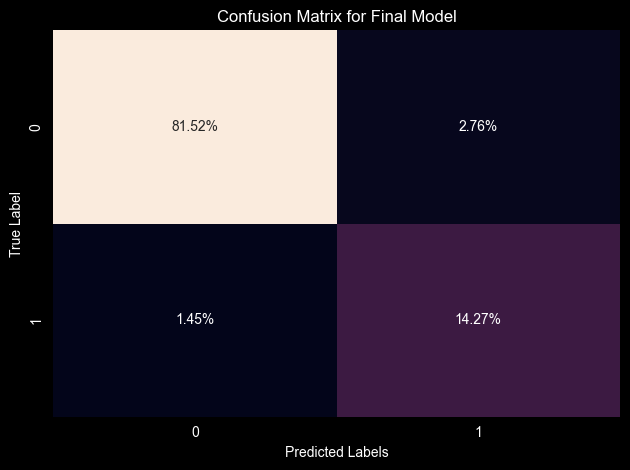

In [24]:
final_model = HistGradientBoostingClassifier(class_weight = 'balanced', min_samples_leaf=36, learning_rate=0.1, l2_regularization=.1, max_iter=150)

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5)
cm = np.zeros((2,2))

for train_inds, test_inds in cv.split(df[predictor_keys], df[label_key].values.ravel()):
    Xtrain = df[predictor_keys].iloc[train_inds]
    Xtest = df[predictor_keys].iloc[test_inds]
    Ytrain = df[label_key].values.ravel()[train_inds]
    Ytest = df[label_key].values.ravel()[test_inds]

    fit_model = final_model.fit(Xtrain, Ytrain)
    y_pred = fit_model.predict(Xtest)
    cm += metrics.confusion_matrix(Ytest, y_pred)

cm = cm / np.sum(cm) * 100
ax = sns.heatmap(cm, annot=True, fmt='.2f', cbar=False)
for text in ax.texts:
    text.set_text(text.get_text() + '%')
plt.title('Confusion Matrix for Final Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Label')
plt.tight_layout()

Seems to be great but remember the class labels are unbalanced so let's check the recall and the precision.

In [6]:
final_model = HistGradientBoostingClassifier(class_weight = 'balanced', min_samples_leaf=36, learning_rate=0.1, l2_regularization=.1, max_iter=150)

Xtrain, Xtest, Ytrain, Ytest = train_test_split(df[predictor_keys], df[label_key].values.ravel(), stratify=df[label_key].values.ravel())
final_model.fit(Xtrain, Ytrain)

recall = metrics.recall_score(Ytest, final_model.predict(Xtest))
precision = metrics.precision_score(Ytest, final_model.predict(Xtest))
print(f'Precision is: {precision:.2f}, Recall is: {recall:.2f}')

Precision is: 0.79, Recall is: 0.89


So about 80% of the customers the model predicted would churn, did churn and about 90% of the customers that were going to churn were caught by the model. That's not terrible and it's probably good for this problem that we lean more towards recall than precision unless we're planning on an intervention that is high cost.

We're now going to look at the Shapley Additive Explanation (shap) values. These are a very useful little tool to *suggest* what variables may be important to the output according to the model and how important they are. It's worth pausing for a moment to remind ourselves that we included many covariate variables in our predictor and haven't done any causal graphing and investigation. We cannot get causal inference from our predictive model, these are two seperate tasks. I'm showing the shap values here because they can be an excellent motivator for future experiments we might want to do to probe the causal structure of our system. 

With the throat clearing done, let's take a look at the violin plot of the shap values. We'll only do a single test train split since we're looking more for the qualitative output rather than the exact quantiative (and SHAP values are NP hard to calculate).

In [7]:
final_model = HistGradientBoostingClassifier(class_weight = 'balanced', min_samples_leaf=36, learning_rate=0.1, l2_regularization=.1, max_iter=150)

Xtrain, Xtest, Ytrain, Ytest = train_test_split(df[predictor_keys], df[label_key].values.ravel(), stratify=df[label_key].values.ravel())
final_model.fit(Xtrain, Ytrain)

def model_wrapper(X):
    return final_model.predict(X)

explainer = shap.Explainer(model_wrapper, Xtrain)
shap_values = explainer(Xtest)

PermutationExplainer explainer: 789it [01:56,  6.29it/s]                         


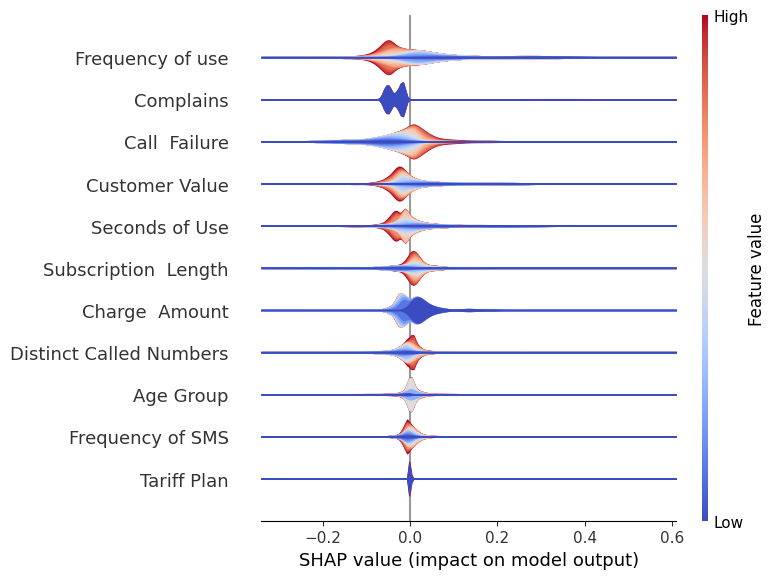

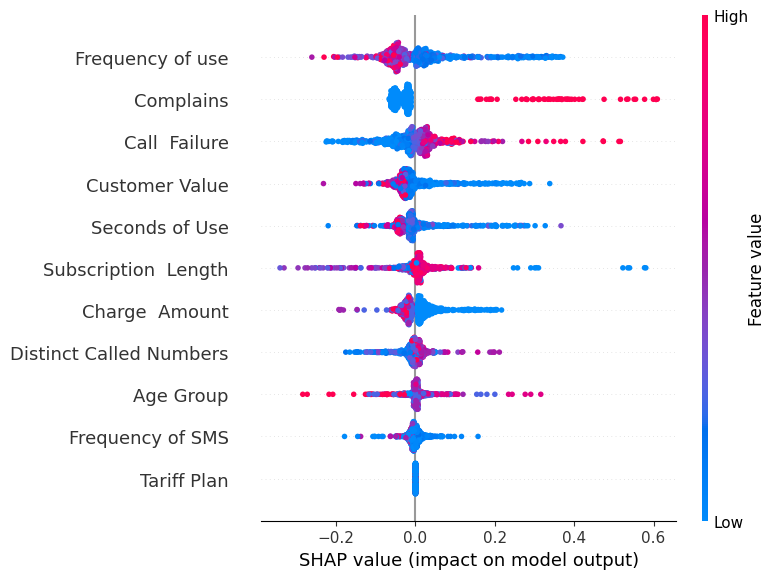

In [30]:
with plt.style.context('default'):
    shap.summary_plot(shap_values, Xtest, plot_type="layered_violin", color = "coolwarm")
    shap.summary_plot(shap_values, Xtest, color = "coolwarm")

Let's go one row at a time and try to think about what the top 5 SHAP values are suggesting and what investigation or action it may prompt (the more positive the more that variable contributed to a positive churn prediction)
- Freq of Use, if people aren't using the service they're much more likely to churn. There's still plenty of blue to the left of 0 though so it's not a guarantee. Perhaps we should look more into what is different between points in the long tail to the right since the feature value isn't changing much
- Complains, this is a binary feature so if the customer complains it seems to have a major impact on churn probability. It could suggest that how we handle complaints is seemingly ineffective to our customers since it's the 2nd most impactful
- Seconds of use, same interpretation as frequency of use, they are heavily correlated features so not suprisingly to see essentially a copy
- Customer Value, it seems that the less valuble customers are the more likely to churn which is interesting. That's pretty good for us and might inform how many resources we actually want to put in to retaining those customers.
- Call Failure, unsuprisingly if people experience call failures it makes them more likely to leave us. Maybe by setting up an experiment where we offer some kind of credit or ammelioration after a call failure we can avoid the negative impact.

## Conclusions, suggested next steps <a class="anchor" name="7"></a>

We've built a model that allows us to predict which customers will churn with
- An accuracy of ~95.5%
- A precision of 80% (percent of customers that the model predicted would churn who did)
- A recall of 90% (percent of customers who churned that the model caught)

All in cross validation, if the behavior of our customers shifts when compared to the 12 months we took this data, it's expected this accuracy wil decrease so frequent retraining and re-appraisal will be needed.

I consider most of the error being from false positives to be a good thing for this task, it's better for us to try to keep a customer who might not strictly need it than to lose a customer without any warning.

The model itself is sklearn's HistGradientBoostingClassifier with the follow kwargs
- class_weight = 'balanced'
- min_samples_leaf = 36
- learning_rate = 0.1
- l2_regularization = 0.1
- max_iter = 150

The SHAP values combined with our earlier EDA suggest these important three things
- Customers who don't use the service or use it less are more likely to churn
- Customers who churn tend to be of low customer value
- When a customer experiences a negative event with us (they complain or they experience call failures) they quickly become likely to churn

I suggest choosing between:
- Doing nothing, the customers who churn are almost always below the average customer value (see EDA) with very few exceptions.
- Set up an A/B experiment where we start trying different responses to call failures and complaints. The shap values could be suggesting that something about how we handle those makes someone more likely to leave. It would be good to experiment with seperating the event and the response effect on churn.
- Set up an A/B experiment where we try to get people who aren't using the service much to use it more. This could be done through gamification elements, small amounts of free credit, or other hooks to try to get them used to using the service.

Thanks for reading!